In [1]:
!git clone https://github.com/RishiPratap/Deep-fake-Detection-app.git
%cd Deep-fake-Detection-app


fatal: destination path 'Deep-fake-Detection-app' already exists and is not an empty directory.
/content/Deep-fake-Detection-app


In [1]:
!pip install -q numpy==1.26.4 opencv-python-headless==4.8.0.76 Pillow==10.2.0 tensorflow==2.16.1


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.19.0 requires tensorflow<2.20,>=2.19.0, but you have tensorflow 2.16.1 which is incompatible.
jax 0.5.3 requires ml_dtypes>=0.4.0, but you have ml-dtypes 0.3.2 which is incompatible.
tf-keras 2.19.0 requires tensorflow<2.20,>=2.19, but you have tensorflow 2.16.1 which is incompatible.
tensorstore 0.1.76 requires ml_dtypes>=0.5.0, but you have ml-dtypes 0.3.2 which is incompatible.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, but you have tensorflow 2.16.1 which is incompatible.


In [2]:
import urllib.request

model_url = "https://raw.githubusercontent.com/RishiPratap/Deep-fake-Detection-app/main/deepfake_detection_model.tflite"

# تحميل النموذج
urllib.request.urlretrieve(model_url, "deepfake_detection_model.tflite")

print("✅ تم تحميل نموذج TFLite بنجاح!")


✅ تم تحميل نموذج TFLite بنجاح!


In [3]:
!pip uninstall -y numpy ml_dtypes
!pip install numpy==1.26.4 ml_dtypes


Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: ml-dtypes 0.3.2
Uninstalling ml-dtypes-0.3.2:
  Successfully uninstalled ml-dtypes-0.3.2
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached ml_dtypes-0.5.3-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (8.9 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
Using cached ml_dtypes-0.5.3-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (4.9 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.16.1 requires ml-dtypes~=0.3.1, but you have ml-dtypes 0.5.3 which is incompatible.
albumentations 2.0.8 requires opencv-python-headless>=4.9.0.80, but you have opencv-python-head

In [4]:
from tensorflow.lite.python.interpreter import Interpreter
import numpy as np

# تحميل النموذج
interpreter = Interpreter(model_path="deepfake_detection_model.tflite")
interpreter.allocate_tensors()

# تفاصيل الإدخال والإخراج
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("✅ تم تحميل النموذج وتخصيص الذاكرة بنجاح!")


✅ تم تحميل النموذج وتخصيص الذاكرة بنجاح!


In [5]:
from google.colab import files

uploaded_video = files.upload()  # هيظهرلك زر لاختيار الفيديو
video_path = list(uploaded_video.keys())[0]

print(f"📁 تم رفع الفيديو: {video_path}")


Saving 02__podium_speech_happy.mp4 to 02__podium_speech_happy.mp4
📁 تم رفع الفيديو: 02__podium_speech_happy.mp4


In [6]:
import cv2
import numpy as np

def extract_frames(video_path, num_frames=10):
    frames = []
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # نحاول ناخد إطارات موزعة بالتساوي على طول الفيديو
    step = max(1, total_frames // num_frames)

    for i in range(0, total_frames, step):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
        if len(frames) == num_frames:
            break
    cap.release()
    return frames

# استخراج الإطارات
frames = extract_frames(video_path)
print(f"📸 تم استخراج {len(frames)} إطار من الفيديو.")


📸 تم استخراج 10 إطار من الفيديو.


In [7]:
def preprocess_frames(frames):
    preprocessed = []
    for frame in frames:
        frame = cv2.resize(frame, (224, 224))  # حجم الإدخال المتوقع
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # من BGR إلى RGB
        frame = frame.astype(np.float32) / 255.0        # تحويل إلى [0,1]
        preprocessed.append(frame)
    return np.array(preprocessed)

# تطبيق المعالجة المسبقة
processed_frames = preprocess_frames(frames)
print(f"✅ تم تنفيذ المعالجة المسبقة: {processed_frames.shape}")


✅ تم تنفيذ المعالجة المسبقة: (10, 224, 224, 3)


In [8]:
def preprocess_frames(frames):
    preprocessed = []
    for frame in frames:
        resized = cv2.resize(frame, (224, 224))  # حجم الإدخال المناسب للموديل
        rgb = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)  # من BGR إلى RGB
        normalized = rgb / 255.0  # تحويل القيم إلى بين 0 و 1
        preprocessed.append(normalized)
    return np.array(preprocessed, dtype=np.float32)

 # معالجة الإطارات
input_data = preprocess_frames(frames)

# إضافة بعد batch للمصفوفة (عدد الإطارات × 224 × 224 × 3)
input_data = np.expand_dims(input_data, axis=0)

print(f"✅ شكل بيانات الإدخال للموديل: {input_data.shape}")



✅ شكل بيانات الإدخال للموديل: (1, 10, 224, 224, 3)


In [9]:
# إعداد النموذج للإدخال
interpreter.set_tensor(input_details[0]['index'], input_data)

# تشغيل النموذج
interpreter.invoke()

# استخراج التنبؤ
output_data = interpreter.get_tensor(output_details[0]['index'])

# عرض التنبؤ
print("🔍 نتيجة النموذج:", output_data)


🔍 نتيجة النموذج: [[0.61980873]]


Predication: REAL (score = 0.42)


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


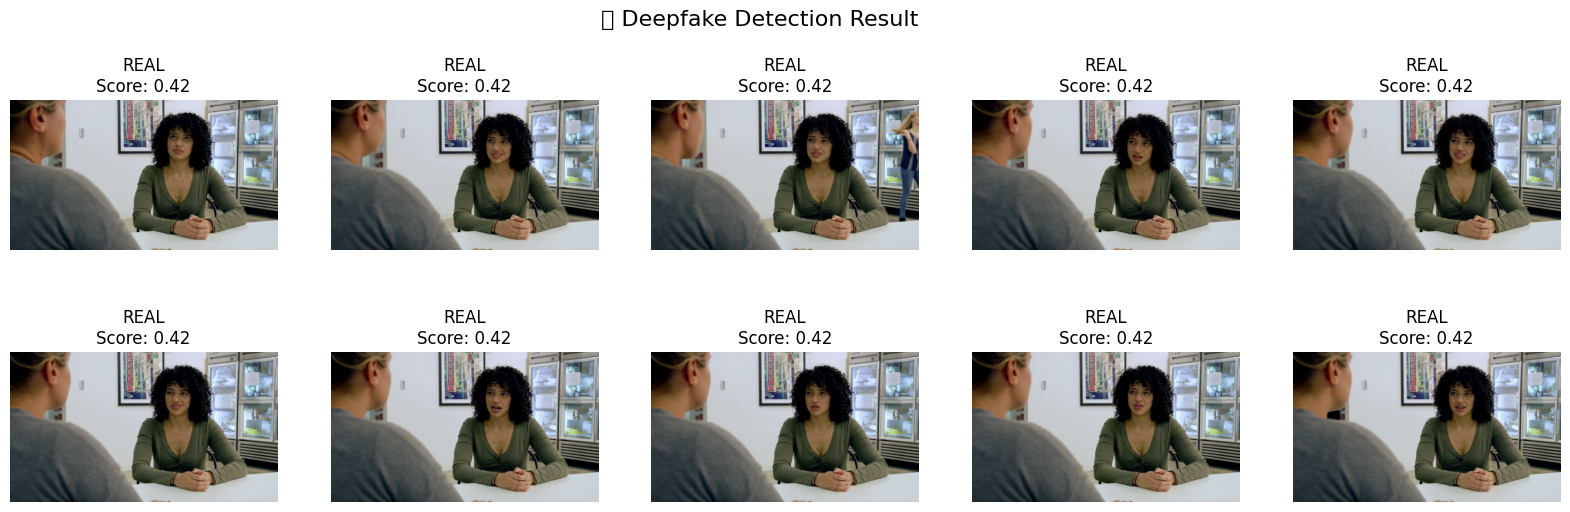

In [ ]:
import matplotlib.pyplot as plt
# تفسير النتيجة
score = float(output_data[0][0])
prediction = "FAKE" if score > 0.5 else "REAL"

print(f"Predication: {prediction} (score = {score:.2f})")

# عرض الإطارات والتنبؤ
plt.figure(figsize=(20, 6))
for i, frame in enumerate(frames):
    plt.subplot(2, 5, i+1)
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb)
    plt.axis('off')
    plt.title(f"{prediction}\nScore: {score:.2f}")
plt.suptitle("🧠 Deepfake Detection Result", fontsize=16)
plt.show()


In [10]:
# التنبؤ الأساسي باستخدام الفيديو الكامل (10 فريمات)
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
original_output = interpreter.get_tensor(output_details[0]['index'])

# تفسير التنبؤ
score = float(original_output[0][0])
prediction = "FAKE" if score > 0.5 else "REAL"

print(f"Predication: {prediction} (score = {score:.2f})")


Predication: FAKE (score = 0.62)


In [11]:
# قائمة لتخزين مدى تأثير كل فريم على النتيجة
frame_importances = []

# المرور على كل فريم من الفريمات العشرة
for i in range(10):
    # إنشاء نسخة من البيانات
    modified_input = input_data.copy()

    # تعويض الفريم i بمصفوفة أصفار
    modified_input[0, i] = np.zeros((224, 224, 3), dtype=np.float32)

    # إعادة تمرير المدخل المعدل للموديل
    interpreter.set_tensor(input_details[0]['index'], modified_input)
    interpreter.invoke()
    modified_output = interpreter.get_tensor(output_details[0]['index'])

    # حساب الفرق
    diff = abs(score - float(modified_output[0][0]))
    frame_importances.append(diff)

    print(f"📊 فريم {i+1} تأثيره: {diff:.4f}")


📊 فريم 1 تأثيره: 0.0325
📊 فريم 2 تأثيره: 0.0278
📊 فريم 3 تأثيره: 0.0157
📊 فريم 4 تأثيره: 0.0102
📊 فريم 5 تأثيره: 0.0035
📊 فريم 6 تأثيره: 0.0004
📊 فريم 7 تأثيره: 0.0012
📊 فريم 8 تأثيره: 0.0005
📊 فريم 9 تأثيره: 0.0004
📊 فريم 10 تأثيره: 0.0004


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


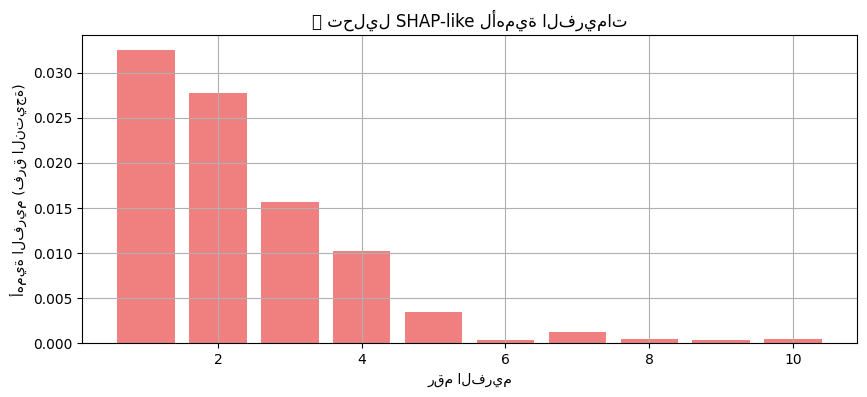

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.bar(range(1, 11), frame_importances, color='lightcoral')
plt.xlabel("رقم الفريم")
plt.ylabel("أهمية الفريم (فرق النتيجة)")
plt.title("📈 تحليل SHAP-like لأهمية الفريمات")
plt.grid(True)
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


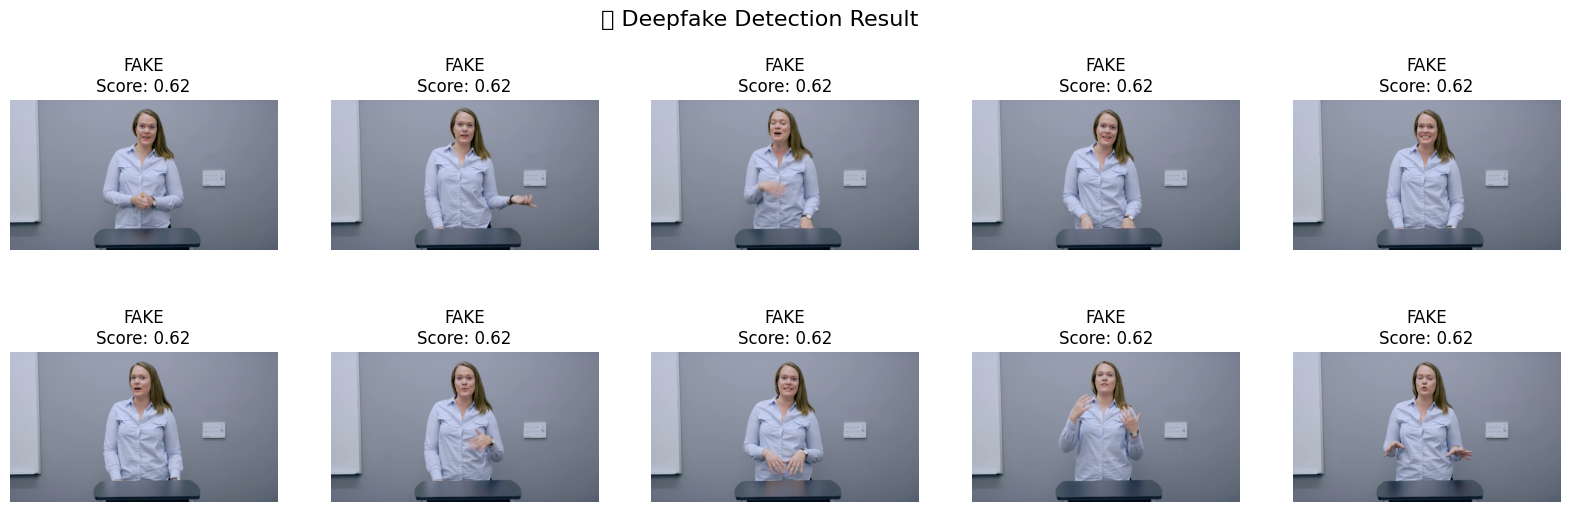

In [13]:
import matplotlib.pyplot as plt

# عرض الإطارات والتنبؤ
plt.figure(figsize=(20, 6))
for i, frame in enumerate(frames):
    plt.subplot(2, 5, i+1)
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb)
    plt.axis('off')
    plt.title(f"{prediction}\nScore: {score:.2f}")
plt.suptitle("🧠 Deepfake Detection Result", fontsize=16)
plt.show()


In [14]:
# تحديد الفريم الأكثر تأثيرًا
most_important_frame_index = np.argmax(frame_importances)
most_important_frame = frames[most_important_frame_index]

print(f"🎯 الفريم رقم {most_important_frame_index + 1} هو الأكثر تأثيرًا في النتيجة.")


🎯 الفريم رقم 1 هو الأكثر تأثيرًا في النتيجة.


In [15]:
def perturb_and_explain(frame, input_data, frame_index, grid_size=4):
    h, w, _ = frame.shape
    region_h, region_w = h // grid_size, w // grid_size

    importance_map = np.zeros((grid_size, grid_size))

    for i in range(grid_size):
        for j in range(grid_size):
            # نسخة من الإطار مع إخفاء منطقة محددة
            perturbed_frame = frame.copy()
            perturbed_frame[i*region_h:(i+1)*region_h, j*region_w:(j+1)*region_w] = 0

            # نفس المعالجة السابقة
            processed = preprocess_frames([perturbed_frame])[0]  # (224, 224, 3)

            # نسخة من الإدخال الكلي مع الفريم المعدل
            modified_input = input_data.copy()
            modified_input[0, frame_index] = processed

            # تمرير للنموذج
            interpreter.set_tensor(input_details[0]['index'], modified_input)
            interpreter.invoke()
            modified_output = interpreter.get_tensor(output_details[0]['index'])
            new_score = float(modified_output[0][0])

            # الفرق في النتيجة
            diff = abs(score - new_score)
            importance_map[i, j] = diff

    return importance_map


In [ ]:
# احسب خريطة التأثير للمناطق
importance_map = perturb_and_explain(most_important_frame, input_data, most_important_frame_index, grid_size=4)


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


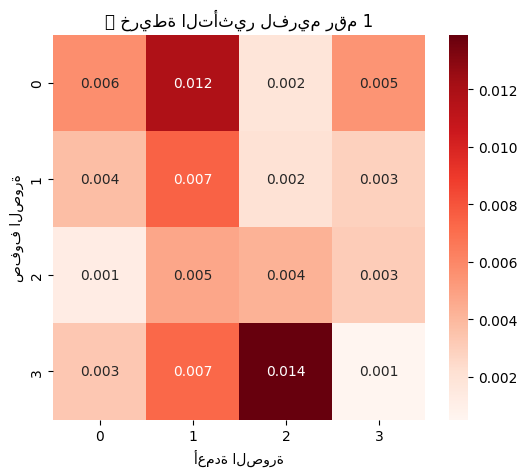

In [ ]:
import seaborn as sns

plt.figure(figsize=(6, 5))
sns.heatmap(importance_map, annot=True, fmt=".3f", cmap='Reds')
plt.title(f"🔥 خريطة التأثير لفريم رقم {most_important_frame_index + 1}")
plt.xlabel("أعمدة الصورة")
plt.ylabel("صفوف الصورة")
plt.show()


In [20]:
import numpy as np

grid_size = 16  # لأن الجدول كان 16x4
importance_map = np.zeros((grid_size, grid_size))

# نشتغل على أول فريم (أو الفريم الأكثر تأثيراً)
frame_to_analyze = processed_frames[0]  # شكلها (224,224,3)

region_h, region_w = 224 // grid_size, 224 // grid_size

# نمر على الشبكة 4x4
for i in range(grid_size):
    for j in range(grid_size):
        modified_input = input_data.copy()

        # نحذف المنطقة
        modified_input[0, 0, i*region_h:(i+1)*region_h, j*region_w:(j+1)*region_w, :] = 0

        # نعيد التنبؤ
        interpreter.set_tensor(input_details[0]['index'], modified_input)
        interpreter.invoke()
        modified_output = interpreter.get_tensor(output_details[0]['index'])

        diff = abs(score - float(modified_output[0][0]))
        importance_map[i, j] = diff

print("📊 Importance Map Shape:", importance_map.shape)
print(importance_map)


📊 Importance Map Shape: (16, 16)
[[2.05558538e-03 4.12350893e-03 9.25630331e-03 1.51258707e-03
  5.32329082e-04 5.54299355e-03 1.14601851e-03 1.11633539e-03
  6.36094809e-03 1.04078650e-02 3.77225876e-03 2.94607878e-03
  5.41514158e-03 5.58847189e-03 5.30284643e-03 2.88552046e-03]
 [2.09444761e-03 2.22688913e-03 3.98606062e-03 9.76026058e-04
  4.19437885e-04 2.20060349e-04 3.16303968e-03 1.29075050e-02
  6.27028942e-03 5.29158115e-03 7.32541084e-04 2.00366974e-03
  5.51939011e-04 6.58470392e-03 1.89483166e-04 2.21908092e-03]
 [1.13202929e-02 6.55263662e-03 1.32799149e-04 1.33675337e-03
  2.12275982e-03 1.06441975e-03 1.32983923e-03 9.61363316e-04
  7.86465406e-03 9.69052315e-04 2.56896019e-05 1.05124712e-03
  7.83801079e-05 1.68174505e-03 1.94394588e-03 1.40625238e-03]
 [4.09364700e-03 8.58765841e-03 1.29610300e-03 3.27885151e-04
  3.39156389e-03 1.90454721e-03 1.87933445e-04 4.70817089e-04
  1.07818842e-03 2.77435780e-03 3.25053930e-03 7.45600462e-03
  2.09629536e-03 6.13421202e-03 4.

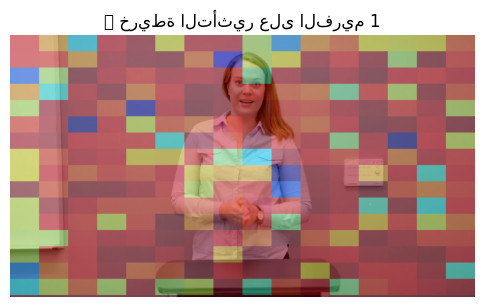

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def overlay_heatmap_on_frame(frame, importance_map):
    grid_size = importance_map.shape[0]
    h, w, _ = frame.shape
    heatmap_img = frame.copy()

    # نكرر قيمة كل خلية على المساحة المقابلة لها في الصورة
    overlay = np.zeros((h, w), dtype=np.float32)
    region_h, region_w = h // grid_size, w // grid_size

    for i in range(grid_size):
        for j in range(grid_size):
            overlay[i*region_h:(i+1)*region_h, j*region_w:(j+1)*region_w] = importance_map[i, j]

    # تحويل الماب لـ ألوان
    overlay_norm = cv2.normalize(overlay, None, 0, 255, cv2.NORM_MINMAX)
    overlay_colored = cv2.applyColorMap(overlay_norm.astype(np.uint8), cv2.COLORMAP_JET)

    # دمج مع الصورة الأصلية
    blended = cv2.addWeighted(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), 0.6, overlay_colored, 0.4, 0)
    return blended

# تطبيق الدالة
blended_frame = overlay_heatmap_on_frame(most_important_frame, importance_map)

# عرض النتيجة
plt.figure(figsize=(6,6))
plt.imshow(blended_frame)
plt.axis('off')
plt.title(f"🎯 خريطة التأثير على الفريم {most_important_frame_index+1}")
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


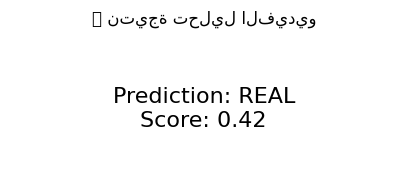

In [ ]:
from IPython.display import Video, display
import matplotlib.pyplot as plt
import cv2

# عرض الفيديو
display(Video(video_path))

# عرض النتيجة
plt.figure(figsize=(5, 2))
plt.text(0.5, 0.5, f"Prediction: {prediction}\nScore: {score:.2f}", fontsize=16,
         ha='center', va='center')
plt.axis('off')
plt.title("🔍 نتيجة تحليل الفيديو")
plt.show()
